# PART 1 – Baseline Modelling and Hyper‑parameter Tuning for Amazon Review Sentiment

**Purpose**  
Establish strong traditional baselines (TF‑IDF + Logistic Regression / Linear SVM) and select optimal hyper‑parameters before moving to transformer‑based fine‑tuning.

**Workflow Overview**  
1. **Data acquisition** — Downloads the Kaggle Amazon‑Reviews CSVs via the Kaggle API, or re‑uses local copies when present.  
2. **Data curation** —  
   • Merges `title` + `text` into `content`.  
   • Converts 5‑point `polarity` to a binary `label` (0 = negative, 1 = positive).  
   • Creates a stratified `train / validation / test` `DatasetDict` for reproducibility.  
3. **Exploratory analysis** — Plots class balance and review‑length distributions to guide preprocessing decisions.  
4. **Text‑cleaning pipeline** — Optional spaCy‑based lemmatisation + stop‑word/punctuation removal producing a `clean` column.  
5. **Baseline models** —  
   • Fits TF‑IDF (1–2 grams, 50 k features).  
   • Trains and evaluates Logistic Regression and Linear SVM on both **raw** and **clean** text.  
   • Reports Accuracy, Precision, Recall, F1, and confusion matrices.  
6. **Hyper‑parameter sweep** — Grid‑searches C, loss, and solver variants (3‑fold CV) to pick the best BOW classifier.  
7. **Artifact management** — Saves vectoriser, tuned classifier, plots, and metrics under  
   `/content/amazon_reviews_data/artifacts/`.

**Key Outputs**  
* Validation metric tables & plots for quick model comparison.  
* `best_tfidf_vectorizer.joblib` and `best_classifier_model.joblib` ready for deployment.  

### Dependencies to install

In [3]:
!pip install -U datasets
!pip install -q tqdm-joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

### UNZIP YOUR DATA IF YOU ALREADY HAVE IT

In [2]:
# !unzip /content/amazon_reviews_data.zip

Archive:  /content/amazon_reviews_data.zip
   creating: amazon_reviews_data/
   creating: amazon_reviews_data/arrow_clean/
  inflating: amazon_reviews_data/arrow_clean/dataset_dict.json  
   creating: amazon_reviews_data/arrow_clean/test/
  inflating: amazon_reviews_data/arrow_clean/test/data-00000-of-00001.arrow  
  inflating: amazon_reviews_data/arrow_clean/test/dataset_info.json  
  inflating: amazon_reviews_data/arrow_clean/test/state.json  
   creating: amazon_reviews_data/arrow_clean/train/
  inflating: amazon_reviews_data/arrow_clean/train/data-00000-of-00001.arrow  
  inflating: amazon_reviews_data/arrow_clean/train/dataset_info.json  
  inflating: amazon_reviews_data/arrow_clean/train/state.json  
   creating: amazon_reviews_data/arrow_clean/validation/
  inflating: amazon_reviews_data/arrow_clean/validation/data-00000-of-00001.arrow  
  inflating: amazon_reviews_data/arrow_clean/validation/dataset_info.json  
  inflating: amazon_reviews_data/arrow_clean/validation/state.json 

### Imports and Setup

In [4]:
import os
import random
import zipfile
import shutil
import re
import csv
import html
from pathlib import Path
from typing import List, Tuple, Dict, Any, Optional
import sys
import subprocess

import numpy as np, logging
import pandas as pd
import spacy
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix
)
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.pipeline import Pipeline

# Hugging Face Datasets imports
from datasets import Dataset, DatasetDict, load_from_disk
import pyarrow as pa
import pyarrow.parquet as pq

# Joblib for saving models
from joblib import dump, load

print("Libraries imported.")








Libraries imported.


### Configuration data

In [8]:
CONFIG = {
    "TRAIN_ROWS":     60_000,
    "TEST_ROWS":       10_000,
    "VAL_FRACTION":     0.15,           # 15% of train subset for validation
    "KAGGLE_DATASET": "kritanjalijain/amazon-reviews",
    "BASE_DATA_DIR":  "/content/amazon_reviews_data", # Base directory for all data
    "MAX_TFIDF":      50_000,          # Max features for TF-IDF
    "CV_FOLDS":       3,               # Folds for cross-validation (reduce for speed)
    "SEED":           42,
    "SPACY_MODEL":    "en_core_web_sm",
    "EMBEDDING_DIM":  768              # Example dimension for placeholder embeddings
}

# Derived paths
BASE_DATA_DIR = Path(CONFIG["BASE_DATA_DIR"])
RAW_DATA_DIR = BASE_DATA_DIR / "raw_kaggle"
CLEAN_DATA_DIR = BASE_DATA_DIR / "arrow_clean"
ARTIFACT_DIR = BASE_DATA_DIR / "artifacts"
EMBEDDING_DIR = BASE_DATA_DIR / "embeddings_placeholder"

# Create directories
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
CLEAN_DATA_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# Set Seed
random.seed(CONFIG["SEED"])
np.random.seed(CONFIG["SEED"])
print(f" Configuration set. Seed: {CONFIG['SEED']}.")
print(f"   Base data directory: {BASE_DATA_DIR}")
print(f"   Raw data directory: {RAW_DATA_DIR}")
print(f"   Clean data directory: {CLEAN_DATA_DIR}")
print(f"   Artifacts directory: {ARTIFACT_DIR}")
print(f"   Embeddings directory: {EMBEDDING_DIR}")

 Configuration set. Seed: 42.
   Base data directory: /content/amazon_reviews_data
   Raw data directory: /content/amazon_reviews_data/raw_kaggle
   Clean data directory: /content/amazon_reviews_data/arrow_clean
   Artifacts directory: /content/amazon_reviews_data/artifacts
   Embeddings directory: /content/amazon_reviews_data/embeddings_placeholder


### Upload your kaggle.json file to download the data

In [ ]:

def setup_kaggle_credentials() -> None:
    """Checks for kaggle.json and prompts upload if missing (Colab context)."""
    kaggle_json = Path.home() / ".kaggle" / "kaggle.json"
    if kaggle_json.exists():
        print(f"Found existing Kaggle creds → {kaggle_json} (upload skipped)")
        # Ensure permissions are correct even if file exists
        try:
            os.chmod(kaggle_json, 0o600)
        except OSError as e:
            print(f"Warning: Could not set permissions on {kaggle_json}. Error: {e}")
        return

    print(" KAGGLE API credentials (`kaggle.json`) not found.")
    # Check if running in Colab
    if 'google.colab' in sys.modules:
        from google.colab import files
        print(" Please upload your `kaggle.json` file:")
        uploaded = files.upload()
        if "kaggle.json" not in uploaded:
            print("ERROR: `kaggle.json` not found in uploaded files. Please re-run cell and upload.")
            return # Don't exit, allow user to retry

        kaggle_dir = kaggle_json.parent
        try:
            kaggle_dir.mkdir(mode=0o700, exist_ok=True)
            shutil.move("kaggle.json", kaggle_json)
            os.chmod(kaggle_json, 0o600)
            print(f"✓ Successfully installed Kaggle creds to {kaggle_json}")
        except Exception as e:
            print(f"ERROR: Failed to set up Kaggle credentials: {e}")
    else:
        print(" Not running in Google Colab.")
        print(f" Please ensure `kaggle.json` exists at: {kaggle_json}")
        print(" And that it has the correct permissions (readable only by you).")
        if not kaggle_json.exists():
             print("ERROR: Kaggle credentials file is required to download data.")

# Execute credential setup
setup_kaggle_credentials()

 KAGGLE API credentials (`kaggle.json`) not found.
 Please upload your `kaggle.json` file:


Saving kaggle.json to kaggle.json
✓ Successfully installed Kaggle creds to /root/.kaggle/kaggle.json


### Download the Kaggle dataset if you don't have the .parquet

In [ ]:
def download_and_extract_dataset() -> bool:
    """Downloads and extracts the Kaggle dataset if CSVs are not present. Returns True if successful."""
    train_csv = RAW_DATA_DIR / "train.csv"
    test_csv = RAW_DATA_DIR / "test.csv"

    # Check if files already exist
    if train_csv.exists() and test_csv.exists():
        print(f"✓ Raw CSV files found in {RAW_DATA_DIR}. Skipping download.")
        return True

    # Check if credentials exist before attempting download
    kaggle_json = Path.home() / ".kaggle" / "kaggle.json"
    if not kaggle_json.exists():
        print("ERROR: Cannot download data. Kaggle credentials not found or setup failed.")
        print("Please re-run the previous cell and ensure `kaggle.json` is uploaded/configured.")
        return False

    print(f"⇩ Downloading Kaggle dataset '{CONFIG['KAGGLE_DATASET']}'...")
    try:
        # Use --unzip flag for direct extraction
        subprocess.run([
            "kaggle", "datasets", "download", "-d", CONFIG["KAGGLE_DATASET"],
            "-p", str(RAW_DATA_DIR), "--force", "--unzip"
        ], check=True, capture_output=True, text=True)
        print(f"✓ Dataset downloaded and extracted to {RAW_DATA_DIR}")
        # Verify extraction
        if not train_csv.exists() or not test_csv.exists():
             print("ERROR: Download seemed successful, but train.csv or test.csv not found after extraction.")
             print("       Check the contents of", RAW_DATA_DIR)
             # Clean up potential zip file if extraction failed
             zip_path = RAW_DATA_DIR / f"{CONFIG['KAGGLE_DATASET'].split('/')[-1]}.zip"
             zip_path.unlink(missing_ok=True)
             return False
        return True
    except FileNotFoundError:
        print("ERROR: `kaggle` CLI not found. Install with `pip install kaggle`. Then rerun.")
        return False
    except subprocess.CalledProcessError as e:
        print(f"ERROR: Kaggle download/extract failed.")
        print(f"Stderr: {e.stderr}")
        # Clean up potentially corrupted zip file
        zip_path = RAW_DATA_DIR / f"{CONFIG['KAGGLE_DATASET'].split('/')[-1]}.zip"
        zip_path.unlink(missing_ok=True)
        return False
    except Exception as e:
         print(f"ERROR: An unexpected error occurred during download/extraction: {e}")
         return False

# Execute download
data_available = download_and_extract_dataset()
if not data_available:
    print("\nHalting execution due to data download failure.")

⇩ Downloading Kaggle dataset 'kritanjalijain/amazon-reviews'...
✓ Dataset downloaded and extracted to /content/amazon_reviews_data/raw_kaggle


### Load & preview raw data

- Verifies that `train.csv` and `test.csv` exist in `RAW_DATA_DIR`.
- Reads the number of rows set in `CONFIG['TRAIN_ROWS']` and `CONFIG['TEST_ROWS']` with `pandas.read_csv`.
- Confirms the three expected columns (`polarity`, `title`, `text`).
- Shuffles each DataFrame with the global random seed (`CONFIG['SEED']`) for reproducibility.
- Shows the first three rows of both splits so you can double‑check the content.

If the files are missing or malformed, clear error messages are printed and `data_available` is set to `False` to prevent later cells from running.

In [ ]:
def load_raw_data() -> Optional[Tuple[pd.DataFrame, pd.DataFrame]]:
    """Loads specified number of rows from train/test CSVs into DataFrames."""
    train_csv = RAW_DATA_DIR / "train.csv"
    test_csv = RAW_DATA_DIR / "test.csv"

    if not train_csv.exists() or not test_csv.exists():
        print("ERROR: Raw CSV files not found. Cannot load data.")
        print("       Please ensure the previous download step was successful.")
        return None

    # Define reading parameters
    read_kw = dict(
        names=["polarity", "title", "text"],
        engine="python",
        sep=",",
        quoting=csv.QUOTE_MINIMAL,
        header=0 # Assume header row exists
    )

    print(f" Reading subset of CSVs (Train: {CONFIG['TRAIN_ROWS']:_}, Test: {CONFIG['TEST_ROWS']:_})...")
    try:
        train_df = pd.read_csv(train_csv, nrows=CONFIG["TRAIN_ROWS"], **read_kw)
        print(f"  Loaded {len(train_df):,} train rows.")
        test_df = pd.read_csv(test_csv, nrows=CONFIG["TEST_ROWS"], **read_kw)
        print(f"  Loaded {len(test_df):,} test rows.")
    except FileNotFoundError:
        print("ERROR: CSV file not found during read attempt. Should not happen if download was ok.")
        return None
    except Exception as e:
        print(f"ERROR: Failed to read CSV files: {e}")
        return None

    # Minimal check for expected columns
    if not all(col in train_df.columns for col in ["polarity", "title", "text"]):
        print("ERROR: Loaded train_df is missing expected columns.")
        print("       Columns found:", train_df.columns)
        return None
    if not all(col in test_df.columns for col in ["polarity", "title", "text"]):
        print("ERROR: Loaded test_df is missing expected columns.")
        print("       Columns found:", test_df.columns)
        return None

    # Shuffle for randomness
    train_df = train_df.sample(frac=1, random_state=CONFIG["SEED"]).reset_index(drop=True)
    test_df = test_df.sample(frac=1, random_state=CONFIG["SEED"]).reset_index(drop=True)
    print("✓ Raw data loaded and shuffled.")
    return train_df, test_df

# Execute loading
if data_available: # Only proceed if download was successful
    raw_data = load_raw_data()
    if raw_data:
        train_df_raw, test_df_raw = raw_data
        print("\nRaw Train DataFrame head:")
        display(train_df_raw.head(3))
        print("\nRaw Test DataFrame head:")
        display(test_df_raw.head(3))
    else:
        print("Halting execution due to data loading failure.")
        data_available = False # Prevent further steps needing data
else:
     print("Skipping data loading as download failed.")


 Reading subset of CSVs (Train: 60_000, Test: 10_000)...
  Loaded 60,000 train rows.
  Loaded 10,000 test rows.
✓ Raw data loaded and shuffled.

Raw Train DataFrame head:


,polarity,title,text
0,1,I still have not recieved the book I ordered 1...,I still have not recieved my book that I order...
1,1,THE WORST!,SO bad it is nearly forgotten. Hollywood turne...
2,2,"The ""Bible"" of Bible books",Over the course of 35 years of teaching a cour...



Raw Test DataFrame head:


,polarity,title,text
0,1,Dream is NOT a delirium,Hobson does not understand the topic he is stu...
1,2,Nice.,Great to have a large capacity water container...
2,1,Way too soft,"It is possible I got a defective ball, but I b..."


### Build a Hugging Face `DatasetDict`

This cell converts the raw pandas DataFrames into a tidy `DatasetDict` with `train`, `validation`, and `test` splits.

**Key steps**

1. **Validate inputs** – checks that both DataFrames exist and have the expected columns.  
2. **Feature engineering**  
   - Creates a binary `label` (0 = negative, 1 = positive).  
   - Merges `title` and `text` into a single `content` field.  
3. **Split training data** – uses `train_test_split` with the fraction set in `CONFIG['VAL_FRACTION']`, stratified by `label` for balanced classes.  
4. **Assemble `DatasetDict`** – wraps each split with `Dataset.from_pandas`, ready for the Transformers pipeline.

If any step fails, clear error messages are printed and later cells are prevented from running by toggling `data_available` to `False`.

In [ ]:
def prepare_huggingface_dataset(train_df: pd.DataFrame, test_df: pd.DataFrame) -> DatasetDict:
    """Converts pandas DataFrames to a Hugging Face DatasetDict with train/validation/test splits."""
    print("Preparing Hugging Face DatasetDict...")

    # Input Validation
    if train_df is None or test_df is None:
         raise ValueError("Input DataFrames cannot be None.")
    required_cols = ["polarity", "title", "text"]
    if not all(col in train_df.columns for col in required_cols):
        raise ValueError(f"Train DataFrame missing required columns: {required_cols}. Found: {train_df.columns}")
    if not all(col in test_df.columns for col in required_cols):
        raise ValueError(f"Test DataFrame missing required columns: {required_cols}. Found: {test_df.columns}")

    # Feature Engineering
    # Work on copies to avoid SettingWithCopyWarning
    train_df_processed = train_df.copy()
    test_df_processed = test_df.copy()

    for df in [train_df_processed, test_df_processed]:
        # Create 'label' column (0 for neg, 1 for pos)
        df["label"] = df["polarity"].apply(lambda x: 1 if x == 2 else 0)
        # Combine 'title' and 'text' into 'content', handling potential NaN values
        df["content"] = df["title"].fillna("") + " " + df["text"].fillna("")
        # Drop original columns
        df.drop(columns=["polarity", "title", "text"], inplace=True)

    print("✓ 'label' and 'content' columns created.")

    # Train/Validation Split
    print(f"⏳ Splitting training data (Validation fraction: {CONFIG['VAL_FRACTION']})...")
    try:
        train_part, val_part = train_test_split(
            train_df_processed,
            test_size=CONFIG["VAL_FRACTION"],
            stratify=train_df_processed["label"], # Ensure class balance in splits
            random_state=CONFIG["SEED"]
        )
    except Exception as e:
        raise RuntimeError(f"Failed to split train/validation data: {e}")

    print(f"  Train split size: {len(train_part):,}")
    print(f"  Validation split size: {len(val_part):,}")
    print(f"  Test split size: {len(test_df_processed):,}")

    # Create DatasetDict
    print("Creating DatasetDict object...")
    try:
        ds = DatasetDict({
            "train":      Dataset.from_pandas(train_part.reset_index(drop=True)),
            "validation": Dataset.from_pandas(val_part.reset_index(drop=True)),
            "test":       Dataset.from_pandas(test_df_processed.reset_index(drop=True)),
        })
    except Exception as e:
         raise RuntimeError(f"Failed to create DatasetDict from pandas DataFrames: {e}")

    print("✓ DatasetDict created successfully:")
    print(ds)
    return ds

# Execute preparation
if data_available:
    try:
        ds_prepared = prepare_huggingface_dataset(train_df_raw, test_df_raw)
        print("\nTrain dataset features:")
        print(ds_prepared["train"].features)
    except (ValueError, RuntimeError) as e:
        print(f"\nERROR during dataset preparation: {e}")
        print("Halting execution.")
        data_available = False
    except NameError:
        print("\nERROR: `train_df_raw` or `test_df_raw` not defined. Was loading skipped or failed?")
        data_available = False
else:
    print("Skipping dataset preparation as previous steps failed.")



⏳ Preparing Hugging Face DatasetDict...
✓ 'label' and 'content' columns created.
⏳ Splitting training data (Validation fraction: 0.15)...
  Train split size: 51,000
  Validation split size: 9,000
  Test split size: 10,000
⏳ Creating DatasetDict object...
✓ DatasetDict created successfully:
DatasetDict({
    train: Dataset({
        features: ['label', 'content'],
        num_rows: 51000
    })
    validation: Dataset({
        features: ['label', 'content'],
        num_rows: 9000
    })
    test: Dataset({
        features: ['label', 'content'],
        num_rows: 10000
    })
})

Train dataset features:
{'label': Value(dtype='int64', id=None), 'content': Value(dtype='string', id=None)}


### Class Balance Chart

**Why this matters**

* A roughly 50 / 50 split tells us the model will not be biased toward one class simply because it sees more of it during training.  
* If one bar were much taller, we’d consider techniques like class weighting, oversampling, or focal loss to avoid a “majority‑class” classifier.


### Review‑Length Histogram
**What this shows**

* Most reviews cluster below *N* characters (peak on the left), with a long tail of very long reviews.  
* Knowing the length distribution helps us choose an appropriate **maximum sequence length** for DistilBERT:  
  * Truncating too short → we lose information from long reviews.  
  * Setting it too high → we waste GPU memory on padding.  
* For traditional n‑gram models (like the TF‑IDF baseline), very long texts dilute term‑frequency signals; longer sequences add lots of “rare” n‑grams that carry little extra sentiment information.



📊 Generating data insight plots...


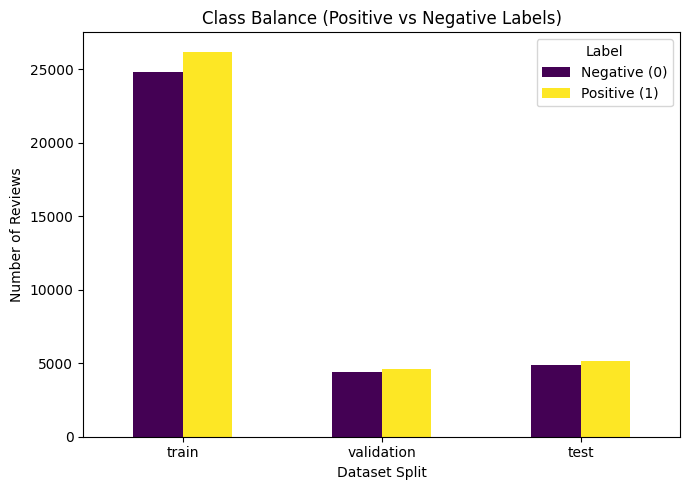

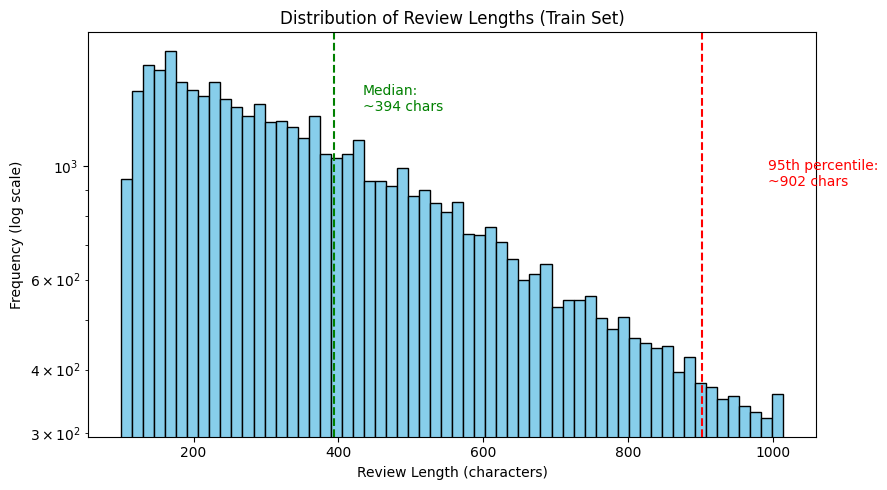

✓ Data insight plots generated (or attempted).


In [ ]:
def plot_data_insights(ds: DatasetDict) -> None:
    """Generates and displays plots for class balance and review length distribution."""
    if not isinstance(ds, DatasetDict):
        print("ERROR: Input must be a Hugging Face DatasetDict.")
        return

    print("\n📊 Generating data insight plots...")

    # --- 1. Class Balance ---
    try:
        fig, ax = plt.subplots(figsize=(7, 5))
        split_counts = {
            split: pd.Series(ds[split]["label"]).value_counts().sort_index()
            for split in ds.keys()
        }
        bar_df = pd.DataFrame(split_counts).T
        bar_df.index.name = "Split"
        bar_df.columns = ["Negative (0)", "Positive (1)"] # Descriptive labels
        bar_df.plot(kind="bar", ax=ax, rot=0, colormap='viridis')
        ax.set_xlabel("Dataset Split")
        ax.set_ylabel("Number of Reviews")
        ax.set_title("Class Balance (Positive vs Negative Labels)")
        ax.legend(title="Label")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"ERROR generating class balance plot: {e}")

    # --- 2. Review Length Histogram (Train split, characters) ---
    try:
        fig, ax = plt.subplots(figsize=(9, 5))
        # Ensure 'content' exists and calculate lengths safely
        if "content" in ds["train"].features:
            lengths = pd.Series([len(text) if isinstance(text, str) else 0 for text in ds["train"]["content"]])
            if not lengths.empty:
                ax.hist(lengths, bins=60, log=True, color='skyblue', edgecolor='black') # Use log scale
                ax.set_xlabel("Review Length (characters)")
                ax.set_ylabel("Frequency (log scale)")
                ax.set_title("Distribution of Review Lengths (Train Set)")

                # Add percentile lines for context
                percentile_50 = np.percentile(lengths, 50)
                percentile_95 = np.percentile(lengths, 95)
                ax.axvline(percentile_50, color='g', linestyle='dashed', linewidth=1.5)
                ax.axvline(percentile_95, color='r', linestyle='dashed', linewidth=1.5)
                max_ylim = ax.get_ylim()[1]
                ax.text(percentile_50 * 1.1, max_ylim * 0.7, f'Median:\n~{percentile_50:.0f} chars', color='g')
                ax.text(percentile_95 * 1.1, max_ylim * 0.5, f'95th percentile:\n~{percentile_95:.0f} chars', color='r')

                plt.tight_layout()
                plt.show()
            else:
                print("WARNING: 'content' column seems empty or invalid for length calculation.")
        else:
             print("WARNING: 'content' column not found in train split. Cannot plot review lengths.")

    except Exception as e:
        print(f"ERROR generating review length plot: {e}")

    print("✓ Data insight plots generated (or attempted).")

# Execute plotting
if data_available:
    plot_data_insights(ds_prepared)
else:
    print("Skipping data exploration plots as data is not available.")
plt.show()

### As we can see the splits are pretty equal no need to change anything there

### Text‑cleaning helpers

This cell prepares the utilities used to turn raw text into a tokenised, lemmatised string suitable for model training.

**Main components**

1. **Regex toolkit**  
   - `URL_RE` replaces web links.  
   - `NUM_RE` replaces numbers.  
   - `WS_RE` normalises whitespace.  
   - `PUNCT_REMOVE_MAP` strips most punctuation but keeps apostrophes for contractions.

2. **spaCy model loader**  
   - `load_spacy_model(name)` loads (and downloads if missing) a specified model with only the tokenizer and tagger, skipping NER and parser for speed.  
   - Handles model re‑loading and gives informative error messages.

3. **Token filter**  
   - `_keep_token(tok)` keeps alphabetic tokens that are either not stop‑words or are explicit negations, preserving sentiment cues like “not”.

4. **`clean_text(text)` pipeline**  
   1. Lower‑cases text, unescapes HTML entities, removes URLs and numbers.  
   2. Applies spaCy for lemmatisation; falls back to simple splitting if the model is unavailable.  
   3. Joins lemmas, removes residual punctuation, and collapses extra spaces.

The function returns a clean string or an empty string for invalid input.

In [ ]:
# Compile regex patterns
URL_RE = re.compile(r'https?://\S+|www\.\S+')
NUM_RE = re.compile(r'\b\d+(?:[\.,]\d+)*\b')
WS_RE = re.compile(r'\s+')
# Keep apostrophes for contractions like "don't" but remove other punctuation
PUNCT_REMOVE_MAP = str.maketrans('', '', r"""!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~""")

NLP = None

def load_spacy_model(model_name: str) -> bool:
    """Loads the spaCy language model, downloading if necessary. Returns True on success."""
    global NLP
    if NLP is not None:
        # Check if the loaded model is the one requested
        if NLP.meta["name"] == model_name.split("_")[-1]:
             print(f"✓ spaCy model '{NLP.meta['lang']}_{NLP.meta['name']}' already loaded.")
             return True
        else:
             print(f" Mismatched spaCy model loaded ({NLP.meta['lang']}_{NLP.meta['name']}). Will load '{model_name}'.")
             NLP = None

    print(f"⏳ Loading spaCy model '{model_name}'...")
    try:
        NLP = spacy.load(model_name, disable=["ner", "parser"]) # Disable unused components for speed
        print(f"✓ spaCy model '{NLP.meta['lang']}_{NLP.meta['name']}' loaded successfully.")
        return True
    except OSError:
        print(f" spaCy model '{model_name}' not found. Attempting download...")
        try:
            subprocess.check_call([sys.executable, "-m", "spacy", "download", model_name])
            NLP = spacy.load(model_name, disable=["ner", "parser"])
            print(f"✓ spaCy model '{model_name}' downloaded and loaded successfully.")
            return True
        except subprocess.CalledProcessError as e:
            print(f"ERROR: Failed to download spaCy model '{model_name}'.")
            print(f"       Command failed: {e.cmd}")
            print(f"       Make sure you have internet access and sufficient permissions.")
            return False
        except Exception as e:
            print(f"ERROR: Failed to load spaCy model '{model_name}' after download attempt. Error: {e}")
            return False

def _keep_token(tok: spacy.tokens.Token) -> bool:
    """Helper to decide if a spaCy token should be kept during cleaning."""
    is_negation = tok.lower_ in ("no", "not", "n't", "never", "cannot", "cant", "dont", "wont")
    # Keep alphabetical tokens that are not stop words OR are negations
    return tok.is_alpha and (not tok.is_stop or is_negation)

def clean_text(text: str) -> str:
    """Applies the full cleaning pipeline to a single string."""
    # 1. Basic Cleaning & Normalization
    if not isinstance(text, str) or not text.strip():
        return "" # Handle None, empty strings, non-strings
    text = html.unescape(text).lower() # Unescape HTML entities, convert to lowercase
    text = URL_RE.sub(' ', text)      # Replace URLs with space
    text = NUM_RE.sub(' ', text)      # Replace numbers with space

    # 2. spaCy Processing
    if NLP is None:
        print("WARNING: spaCy model not loaded. Skipping lemmatization/stopword removal.")
        lemmas = text.split() # Basic split if NLP fails
    else:
        doc = NLP(text)
        lemmas = [
            tok.lemma_.strip() # Get the base form (lemma)
            for tok in doc
            if _keep_token(tok) and tok.lemma_.strip()
        ]

    # 3. Final Cleanup
    text = " ".join(lemmas)                  # Join lemmas back into string
    text = text.translate(PUNCT_REMOVE_MAP) # Remove punctuation
    text = WS_RE.sub(' ', text).strip()     # Normalize whitespace (replace multiple spaces with one)
    return text

### Clean text column and cache the result

- **`load_cleaned_dataset`** checks `CLEAN_DATA_DIR` for a valid cached `DatasetDict` containing both `content` and `clean`.
- **`add_cleaned_text_column`**  
  1. Loads the spaCy model given in `CONFIG['SPACY_MODEL']`.  
  2. Maps `clean_text` over `content` with parallel workers (`num_proc`), adding a new `clean` column.  
  3. Prints a few raw‑vs‑clean examples for a quick check.
- **`save_cleaned_dataset`** writes the processed dataset to disk for future runs.

Execution order  
1. Try to load the cached clean dataset.  
2. If missing or invalid, generate the `clean` column and save.  
3. If cleaning fails, drop any partial `clean` column and continue with the original data.  
4. Update `data_available` if no usable dataset remains.

In [ ]:
def add_cleaned_text_column(ds: DatasetDict) -> Optional[DatasetDict]:
    """Adds a 'clean' column by processing the 'content' column using spaCy."""
    if "clean" in ds["train"].column_names:
        print("✓ 'clean' column already exists. Skipping preprocessing.")
        return ds

    # Load spaCy model first
    spacy_loaded = load_spacy_model(CONFIG["SPACY_MODEL"])
    if not spacy_loaded:
        print("ERROR: spaCy model failed to load. Cannot perform text cleaning.")
        return None

    print(f"\n⏳ Cleaning text data using spaCy ('{CONFIG['SPACY_MODEL']}')...")

    try:
        num_proc = max(1, os.cpu_count() // 2 if os.cpu_count() else 1)
        print(f"  Using {num_proc} processes for mapping.")
        ds_cleaned = ds.map(
            lambda example: {'clean': clean_text(example['content'])},
            num_proc=num_proc,
            desc="Cleaning text",
        )
        print("✓ Text cleaning complete. 'clean' column added.")
        # Display comparison
        print("\nExample comparison (Raw vs Cleaned):")
        for i in range(3):
             print(f"--- Example {i+1} ---")
             print(f"Raw:   {ds_cleaned['train'][i]['content'][:300]}...")
             print(f"Clean: {ds_cleaned['train'][i]['clean'][:300]}...")
        return ds_cleaned

    except Exception as e:
        print(f"ERROR during text cleaning map operation: {e}")
        return None


def save_cleaned_dataset(ds: DatasetDict) -> None:
    """Saves the processed DatasetDict (with 'clean' column) to disk."""
    if not isinstance(ds, DatasetDict) or "clean" not in ds["train"].column_names:
        print("WARNING: Invalid dataset provided or 'clean' column missing. Skipping save.")
        return

    print(f"\nSaving cleaned dataset to {CLEAN_DATA_DIR}...")
    try:
        # Save in Hugging Face's native format
        ds.save_to_disk(str(CLEAN_DATA_DIR))
        print(f"✓ Cleaned dataset saved successfully to {CLEAN_DATA_DIR} (HF format).")


    except Exception as e:
        print(f"Warning: Failed to save cleaned dataset: {e}")


def load_cleaned_dataset() -> Optional[DatasetDict]:
    """Loads the cleaned dataset from disk if it exists and is valid."""
    hf_format_exists = (CLEAN_DATA_DIR / "dataset_dict.json").exists()

    if hf_format_exists:
        print(f"Found cleaned dataset at {CLEAN_DATA_DIR}. Loading from disk...")
        try:
            ds = load_from_disk(str(CLEAN_DATA_DIR))
            # Verify 'clean' and 'content' columns exist
            if "clean" in ds["train"].column_names and "content" in ds["train"].column_names:
                 print("✓ Cleaned dataset loaded successfully.")
                 return ds
            else:
                 print("Warning: Loaded dataset missing 'clean' or 'content' column. Will re-process.")
                 # Clean up potentially incomplete/invalid save
                 try:
                     shutil.rmtree(CLEAN_DATA_DIR)
                     CLEAN_DATA_DIR.mkdir()
                 except OSError as e:
                     print(f" Error cleaning up directory {CLEAN_DATA_DIR}: {e}")
                 return None
        except Exception as e:
            print(f"Warning: Failed to load dataset from {CLEAN_DATA_DIR}: {e}. Will re-process.")
            return None
    else:
        print(" Cleaned dataset not found on disk.")
        return None

# Execution: Load or Create Cleaned Dataset
if data_available:
    ds_clean = load_cleaned_dataset()

    if ds_clean is None:
        print("\nProceeding to clean the text data...")
        ds_clean = add_cleaned_text_column(ds_prepared)
        if ds_clean:
            save_cleaned_dataset(ds_clean)
        else:
            print("ERROR: Text cleaning failed. Cannot proceed with cleaned data.")

            ds_clean = ds_prepared
            if "clean" in ds_clean["train"].column_names:
                 ds_clean = ds_clean.remove_columns("clean")

    if not ds_clean:
        print("\nERROR: No usable dataset available after cleaning attempt.")
        data_available = False

else:
    print("Skipping text cleaning as data is not available.")

# Display info about the final dataset (if available)
if data_available and ds_clean:
    print("\nFinal Dataset Structure:")
    print(ds_clean)
    print("\nColumns available:", ds_clean["train"].column_names)
    if "clean" not in ds_clean["train"].column_names:
         print("WARNING: 'clean' column is not available. Baselines/tuning on clean data will be skipped.")


 Cleaned dataset not found on disk.

Proceeding to clean the text data...
⏳ Loading spaCy model 'en_core_web_sm'...
✓ spaCy model 'en_core_web_sm' loaded successfully.

⏳ Cleaning text data using spaCy ('en_core_web_sm')...
  Using 1 processes for mapping.


Cleaning text:   0%|          | 0/51000 [00:00<?, ? examples/s]

Cleaning text:   0%|          | 0/9000 [00:00<?, ? examples/s]

Cleaning text:   0%|          | 0/10000 [00:00<?, ? examples/s]

✓ Text cleaning complete. 'clean' column added.

Example comparison (Raw vs Cleaned):
--- Example 1 ---
Raw:   So-So She has a good voice and all, but she really needs to think before she goes and starts talking. For example, in the song" Doo Wop, That Thing," she's basically dissing women that have "hair weaves like Europeans." But if you notice her hair in the video- guess what? She's wearing a hair weave ...
Clean: good voice need think go start talk example song doo wop thing basically diss woman hair weave like european notice hair guess wear hair weave bad wig tell song superstar diss rapper sample music background song retread door light fire listen superstar word kill softly song take great deal significa...
--- Example 2 ---
Raw:   It's a vacuum cleaner! Great vacuum cleaner for the price. No expensive filters to buy, along with the pain of changing the filters. It cleans the carpet and wood flooring without spending $400 for a different brand (e.g. Dyson)....
Clean: vacuum cl

Saving the dataset (0/1 shards):   0%|          | 0/51000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

✓ Cleaned dataset saved successfully to /content/amazon_reviews_data/arrow_clean (HF format).

Final Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['label', 'content', 'clean'],
        num_rows: 51000
    })
    validation: Dataset({
        features: ['label', 'content', 'clean'],
        num_rows: 9000
    })
    test: Dataset({
        features: ['label', 'content', 'clean'],
        num_rows: 10000
    })
})

Columns available: ['label', 'content', 'clean']


### Baseline evaluation helpers

**Metric utilities**

| Function | Purpose |
|----------|---------|
| `build_metric_df` | Computes Accuracy, Precision, Recall, and F1 for a list of model outputs and returns a summary DataFrame. |
| `plot_metric_bar` | Plots those metrics as a bar chart for quick visual comparison. |
| `plot_conf_matrices` | Draws confusion‑matrix heat‑maps (one per model) to inspect error types. |

**Text representation**

| Function | Purpose |
|----------|---------|
| `tfidf_vectorize` | Fits a unigram‑bigram TF‑IDF (`max_features = CONFIG['MAX_TFIDF']`) on training text and transforms train/validation/test sets, printing shapes and non‑zero counts. |

**Model runner**

| Function | Purpose |
|----------|---------|
| `run_baseline_model` | Trains a scikit‑learn classifier (e.g., `LogisticRegression`, `LinearSVC`) on TF‑IDF vectors, predicts on the validation split, and returns `(name, y_true, y_pred)` for later metric aggregation. |

The final `print` statement confirms these helpers are ready for baseline experiments.

In [11]:
# Define metric plotting functions here as they are used after baseline runs
def build_metric_df(models_out: List[Tuple[str, np.ndarray, np.ndarray]]) -> pd.DataFrame:
    """Calculates metrics (Acc, Prec, Rec, F1) for model outputs and returns a DataFrame."""
    rows = []
    print("\n--- Validation Set Performance ---")
    if not models_out:
        print("  No model results to process.")
        return pd.DataFrame(rows)

    for name, y_true, y_pred in models_out:
        acc = accuracy_score(y_true, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", pos_label=1, zero_division=0)
        rows.append(dict(Model=name, Accuracy=acc, Precision=prec, Recall=rec, F1=f1))
        print(f"  {name:<20}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")
    print("---------------------------------\n")
    return pd.DataFrame(rows).set_index("Model")


def plot_metric_bar(df_metrics: pd.DataFrame, title: str = "Validation Metrics Comparison") -> None:
    """Plots a bar chart comparing model metrics."""
    if df_metrics.empty:
        print("Skipping metric plot: No metrics available.")
        return
    try:
        fig, ax = plt.subplots(figsize=(max(6, len(df_metrics)*2), 5))
        df_metrics.plot(kind="bar", ax=ax, rot=0, colormap='tab10')
        ax.set_ylim(0, 1.05)
        ax.set_ylabel("Score")
        ax.set_xlabel("Model")
        ax.set_title(title)
        ax.legend(loc='best')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"ERROR plotting metrics: {e}")

def plot_conf_matrices(models_out: List[Tuple[str, np.ndarray, np.ndarray]], title_prefix: str = "Confusion Matrix") -> None:
    """Plots confusion matrices for given model outputs."""
    if not models_out:
        print("Skipping confusion matrix plot: No model results available.")
        return
    num_models = len(models_out)
    try:
        fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 4.5), squeeze=False)
        axes = axes.flatten()

        for i, (name, y_true, y_pred) in enumerate(models_out):
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt="d", cbar=False, ax=axes[i], cmap="Blues",
                        xticklabels=["Predicted Neg (0)", "Predicted Pos (1)"],
                        yticklabels=["True Neg (0)", "True Pos (1)"])
            axes[i].set_xlabel("Predicted Label")
            axes[i].set_ylabel("True Label")
            axes[i].set_title(f"{title_prefix} –\n{name}")

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"ERROR plotting confusion matrices: {e}")


# TF-IDF Vectorization Helper
def tfidf_vectorize(
    train_texts: List[str],
    val_texts: List[str],
    test_texts: Optional[List[str]] = None
) -> Tuple[TfidfVectorizer, np.ndarray, np.ndarray, Optional[np.ndarray]]:
    """Fits TF-IDF on training data and transforms train, validation, and optionally test sets."""
    print(f"\n⏳ Vectorizing text using TF-IDF (max_features={CONFIG['MAX_TFIDF']:_}, ngrams=(1,2))...")
    vectorizer = TfidfVectorizer(
        max_features=CONFIG["MAX_TFIDF"],
        ngram_range=(1, 2),
        dtype=np.float32,
    )
    try:
        X_train = vectorizer.fit_transform(train_texts)
        X_val = vectorizer.transform(val_texts)
        X_test = vectorizer.transform(test_texts) if test_texts is not None else None
        print(f"✓ TF-IDF vectorization complete.")
        print(f"  Train shape={X_train.shape}, NNZ={X_train.nnz:,}")
        print(f"  Validation shape={X_val.shape}")
        if X_test is not None: print(f"  Test shape={X_test.shape}")
        return vectorizer, X_train, X_val, X_test
    except Exception as e:
        print(f"ERROR during TF-IDF vectorization: {e}")
        return None, np.array([]), np.array([]), np.array([])


# Baseline Model Runner Helper
def run_baseline_model(
    model_name: str,
    model_instance, # example: LogisticRegression() or LinearSVC()
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    feature_set_name: str # example: "Raw TF-IDF"
) -> Optional[Tuple[str, np.ndarray, np.ndarray]]:
    """Trains a given sklearn model and evaluates on the validation set."""
    full_model_name = f"{model_name}-{feature_set_name}"
    print(f"\n⏳ Training {full_model_name} baseline...")
    # Check for valid input shapes
    if X_train.shape[0] != y_train.shape[0] or X_val.shape[0] != y_val.shape[0] or X_train.shape[1] != X_val.shape[1]:
        print(f"ERROR: Shape mismatch for {full_model_name}.")
        print(f"       X_train: {X_train.shape}, y_train: {y_train.shape}")
        print(f"       X_val: {X_val.shape}, y_val: {y_val.shape}")
        return None
    if X_train.shape[0] == 0:
         print(f"ERROR: Empty training data for {full_model_name}.")
         return None

    try:
        model_instance.fit(X_train, y_train)
        print(f"✓ {full_model_name} training complete.")
        print(f"⏳ Evaluating {full_model_name} on validation set...")
        y_pred_val = model_instance.predict(X_val)
        # Metrics are calculated and printed later by build_metric_df
        return full_model_name, y_val, y_pred_val
    except Exception as e:
        print(f"ERROR during training/evaluation of {full_model_name}: {e}")
        return None

print("Baseline modeling helper functions defined.")


Baseline modeling helper functions defined.


### Run baseline models on raw text

- **Data setup**  
  - Pulls `label` and `content` from the `train` and `validation` splits.  
  - Converts text to TF‑IDF features (`vec_raw`, `X_train_raw`, `X_val_raw`).

- **Models**  
  1. Logistic Regression (`solver='saga'`, L2, max_iter = 1000).  
  2. Linear SVM (`LinearSVC`, max_iter = 3000).

- **Evaluation & logging**  
  - Each model is trained on the TF‑IDF matrix and predictions are collected.  
  - `build_metric_df` prints and stores Accuracy, Precision, Recall, F1.  
  - `plot_metric_bar` visualises the metrics; `plot_conf_matrices` shows error breakdowns.

If TF‑IDF fails or the dataset is empty, the baselines are skipped.


--- Running Initial Baselines (on Raw 'content') ---

⏳ Vectorizing text using TF-IDF (max_features=50_000, ngrams=(1,2))...
✓ TF-IDF vectorization complete.
  Train shape=(51000, 50000), NNZ=4,849,502
  Validation shape=(9000, 50000)

⏳ Training LogReg-Raw-TFIDF baseline...
✓ LogReg-Raw-TFIDF training complete.
⏳ Evaluating LogReg-Raw-TFIDF on validation set...

⏳ Training SVM-Raw-TFIDF baseline...
✓ SVM-Raw-TFIDF training complete.
⏳ Evaluating SVM-Raw-TFIDF on validation set...

--- Validation Set Performance ---
  LogReg-Raw-TFIDF    : Acc=0.9098, Prec=0.9109, Rec=0.9137, F1=0.9123
  SVM-Raw-TFIDF       : Acc=0.9117, Prec=0.9137, Rec=0.9143, F1=0.9140
---------------------------------



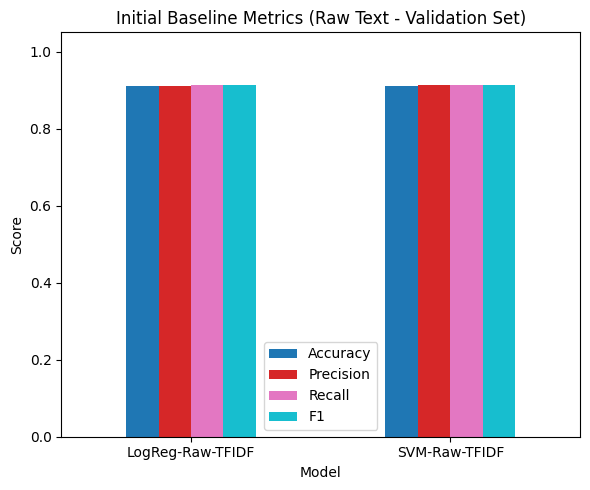

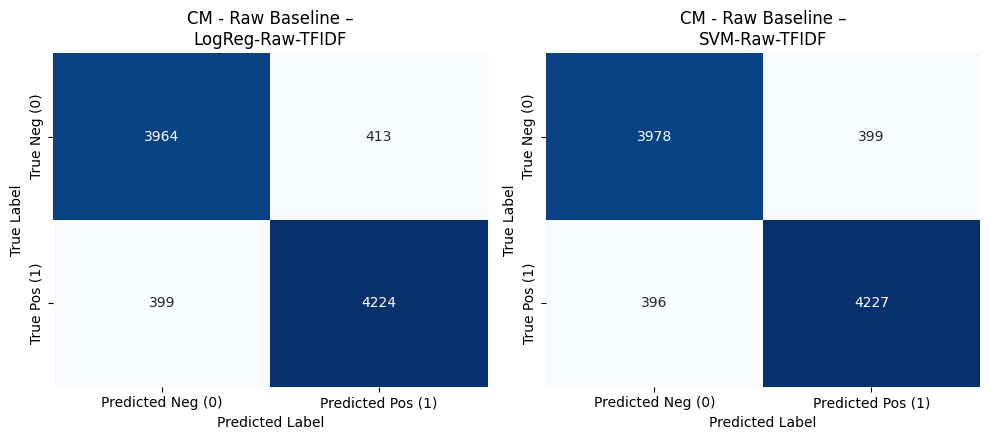

In [ ]:
baseline_results_raw = []

if data_available and ds_clean and "content" in ds_clean["train"].column_names:
    print("\n--- Running Initial Baselines (on Raw 'content') ---")

    # Extract data
    y_train_np = np.array(ds_clean["train"]["label"])
    y_val_np = np.array(ds_clean["validation"]["label"])
    train_texts_raw = ds_clean["train"]["content"]
    val_texts_raw = ds_clean["validation"]["content"]

    # Vectorize raw 'content' text
    vec_raw, X_train_raw, X_val_raw, _ = tfidf_vectorize(train_texts_raw, val_texts_raw)

    if vec_raw is not None and X_train_raw.shape[0] > 0:
        # LogReg Baseline (Raw)
        logreg_raw_model = LogisticRegression(max_iter=1000, C=1.0, random_state=CONFIG["SEED"], n_jobs=-1, solver='saga')
        result_lr = run_baseline_model("LogReg", logreg_raw_model, X_train_raw, y_train_np, X_val_raw, y_val_np, "Raw-TFIDF")
        if result_lr: baseline_results_raw.append(result_lr)

        # SVM Baseline (Raw)
        svm_raw_model = LinearSVC(C=1.0, max_iter=3000, random_state=CONFIG["SEED"], dual=True)
        result_svm = run_baseline_model("SVM", svm_raw_model, X_train_raw, y_train_np, X_val_raw, y_val_np, "Raw-TFIDF")
        if result_svm: baseline_results_raw.append(result_svm)

        # Display results
        metrics_df_raw = build_metric_df(baseline_results_raw)
        if not metrics_df_raw.empty:
            plot_metric_bar(metrics_df_raw, "Initial Baseline Metrics (Raw Text - Validation Set)")
            plot_conf_matrices(baseline_results_raw, "CM - Raw Baseline")
        else:
            print(" No raw baseline results to display.")
    else:
        print(" Skipping raw baselines due to TF-IDF vectorization failure or empty data.")

else:
    print("Skipping Raw Baselines: Data not available or 'content' column missing.")

### Run baseline models on cleaned text

- **Data**  
  - Uses the `clean` column produced by the text‑cleaning pipeline.  
  - Extracts labels and cleaned text for `train` and `validation` splits.

- **Vectorisation**  
  - Converts the cleaned text to unigram‑bigram TF‑IDF features with the same `max_features` setting used for the raw baselines.

- **Models**  
  1. Logistic Regression (`solver='saga'`, L2, max_iter = 1000).  
  2. Linear SVM (`LinearSVC`, max_iter = 3000).

- **Evaluation**  
  - Each model is trained and evaluated on the validation split.  
  - `build_metric_df` prints Accuracy, Precision, Recall, and F1.  
  - Results are visualised with `plot_metric_bar` (metric comparison) and `plot_conf_matrices` (error patterns).

If TF‑IDF vectorisation fails or the dataset is empty, the clean baselines are skipped.


--- Running Initial Baselines (on Cleaned 'clean') ---

⏳ Vectorizing text using TF-IDF (max_features=50_000, ngrams=(1,2))...
✓ TF-IDF vectorization complete.
  Train shape=(51000, 50000), NNZ=1,981,892
  Validation shape=(9000, 50000)

⏳ Training LogReg-Clean-TFIDF baseline...
✓ LogReg-Clean-TFIDF training complete.
⏳ Evaluating LogReg-Clean-TFIDF on validation set...

⏳ Training SVM-Clean-TFIDF baseline...
✓ SVM-Clean-TFIDF training complete.
⏳ Evaluating SVM-Clean-TFIDF on validation set...

--- Validation Set Performance ---
  LogReg-Clean-TFIDF  : Acc=0.8854, Prec=0.8847, Rec=0.8934, F1=0.8890
  SVM-Clean-TFIDF     : Acc=0.8848, Prec=0.8864, Rec=0.8897, F1=0.8880
---------------------------------



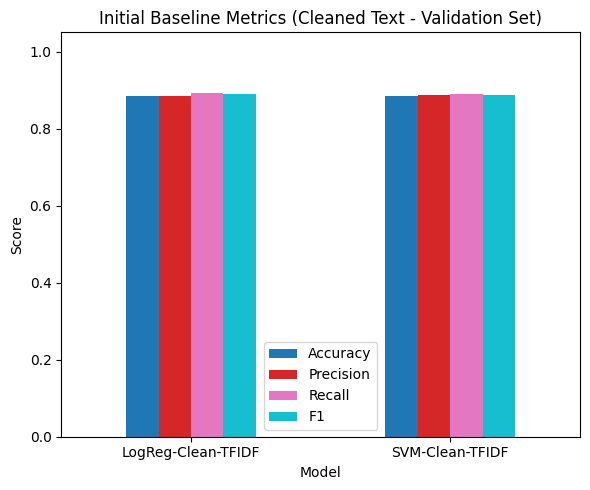

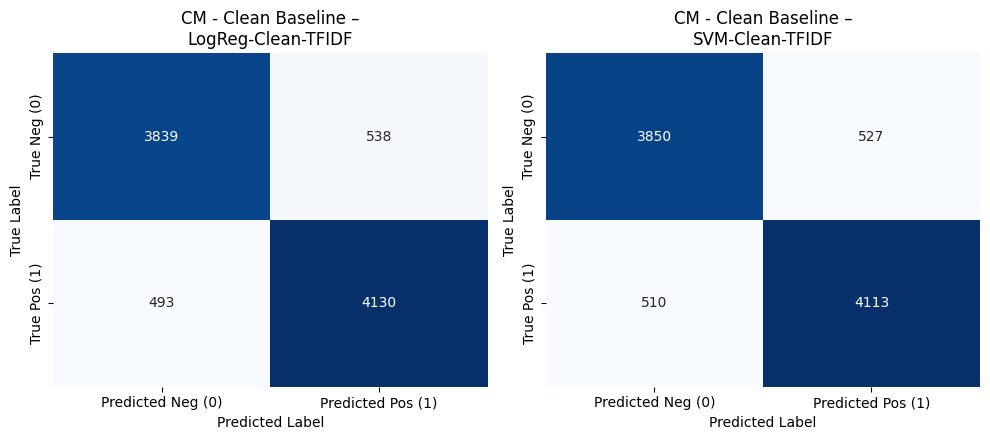

In [ ]:
baseline_results_clean = []

# Check if data and the 'clean' column are available
if data_available and ds_clean and "clean" in ds_clean["train"].column_names:
    print("\n--- Running Initial Baselines (on Cleaned 'clean') ---")

    # Extract data
    y_train_np = np.array(ds_clean["train"]["label"])
    y_val_np = np.array(ds_clean["validation"]["label"])
    train_texts_clean = ds_clean["train"]["clean"]
    val_texts_clean = ds_clean["validation"]["clean"]

    # Vectorize 'clean' text
    vec_clean, X_train_clean, X_val_clean, _ = tfidf_vectorize(train_texts_clean, val_texts_clean)

    # Continue only if vectorization was successful
    if vec_clean is not None and X_train_clean.shape[0] > 0:
        # LogReg Baseline (Clean)
        logreg_clean_model = LogisticRegression(max_iter=1000, C=1.0, random_state=CONFIG["SEED"], n_jobs=-1, solver='saga')
        result_lr_clean = run_baseline_model("LogReg", logreg_clean_model, X_train_clean, y_train_np, X_val_clean, y_val_np, "Clean-TFIDF")
        if result_lr_clean: baseline_results_clean.append(result_lr_clean)

        # SVM Baseline (Clean)
        svm_clean_model = LinearSVC(C=1.0, max_iter=3000, random_state=CONFIG["SEED"], dual=True)
        result_svm_clean = run_baseline_model("SVM", svm_clean_model, X_train_clean, y_train_np, X_val_clean, y_val_np, "Clean-TFIDF")
        if result_svm_clean: baseline_results_clean.append(result_svm_clean)

        # Display results
        metrics_df_clean = build_metric_df(baseline_results_clean)
        if not metrics_df_clean.empty:
            plot_metric_bar(metrics_df_clean, "Initial Baseline Metrics (Cleaned Text - Validation Set)")
            plot_conf_matrices(baseline_results_clean, "CM - Clean Baseline")
        else:
            print(" No clean baseline results to display.")
    else:
        print(" Skipping clean baselines due to TF-IDF vectorization failure or empty data.")

else:
    print("Skipping Clean Baselines: Data not available or 'clean' column missing.")

### Hyper‑parameter sweep setup

- **Parameter grids**
  - `LogReg`: `solver=liblinear`, `penalty=l2`, `C ∈ {0.1, 1, 3}`, `max_iter=300`.
  - `LinearSVM`
    - `hinge` loss, `dual=True`, `C ∈ {0.1, 1, 3}`.
    - `squared_hinge` loss, `dual=False`, same `C` range.
- **`run_hyperparameter_sweep`**
  1. **Combine splits** – joins `train` + `validation` text and labels.
  2. **Vectorise once** – fits a unigram‑bigram TF‑IDF (`max_features = CONFIG['MAX_TFIDF']`), then transforms the combined corpus.
  3. **Grid search**
     - Builds the parameter grid for the chosen model.
     - Estimates total fits (`grid × CV`).
     - Uses `StratifiedKFold` with `CONFIG['CV_FOLDS']`.
     - Executes `GridSearchCV` in parallel (`n_jobs=-1`) with F1 as the metric.
     - Wraps the run in `tqdm_joblib` for a live progress bar.
  4. **Returns** a dict containing the model label, fitted vectoriser, search object, best CV F1, and optimal parameters.

In [ ]:


# classifier grids
def _param_grid(model_name: str):
    """Return a param_grid acceptable to GridSearchCV."""
    if model_name == "LogReg":
        return {
            "solver":   ["liblinear"],          # fast, L2 only, I did not do l1 something was blocking it on one of the iterations and it was taking wayyyy to much time
            "penalty":  ["l2"],
            "C":        [0.1, 1, 3],
            "max_iter": [300],
        }
    elif model_name == "LinearSVM":
      return [
          {
              "loss": ["hinge"],
              "dual": [True],
              "C": [0.1, 1, 3],
              "max_iter": [1000],
          },
          {
              "loss": ["squared_hinge"],
              "dual": [False],
              "C": [0.1, 1, 3],
              "max_iter": [1000],
          },
      ]
    else:
        raise ValueError(model_name)

# main sweep
def run_hyperparameter_sweep(model_name, base_clf, ds, col):
    print(f"\n── Grid search {model_name} on '{col}' ──")

    # TF‑IDF once
    X_text = ds["train"][col] + ds["validation"][col]
    y      = np.hstack([ds["train"]["label"], ds["validation"]["label"]])

    print("⏳ Fitting TF‑IDF …")
    tfidf = TfidfVectorizer(
        max_features=CONFIG["MAX_TFIDF"],
        ngram_range=(1, 2),
        dtype=np.float32,
    ).fit(X_text)
    X = tfidf.transform(X_text)

    # parameter grid
    param_grid = _param_grid(model_name)
    n_cands    = (sum(len(ParameterGrid(g)) for g in param_grid)
                  if isinstance(param_grid, list)
                  else len(ParameterGrid(param_grid)))
    total_fits = n_cands * CONFIG["CV_FOLDS"]
    print(f"⏳ {n_cands} combos → {total_fits} fits …")

    cv = StratifiedKFold(CONFIG["CV_FOLDS"], shuffle=True, random_state=CONFIG["SEED"])

    gs = GridSearchCV(
        estimator=base_clf,
        param_grid=param_grid,
        cv=cv,
        scoring="f1",
        n_jobs=-1,
        verbose=3,
        return_train_score=False,
        error_score="raise",
    )

    logging.basicConfig(level=logging.INFO,
                        format="%(asctime)s %(message)s",
                        datefmt="%H:%M:%S")

    with tqdm_joblib(tqdm(total=total_fits, desc=f"{model_name}-{col}")):
        gs.fit(X, y)

    print(f"finished – best F1={gs.best_score_:.4f}")
    return {
        "Model": f"{model_name}-{col}",
        "Vectoriser": tfidf,
        "SearchObj": gs,
        "CV_F1": gs.best_score_,
        "BestParams": gs.best_params_,
    }


### Hyperparameter tuning sweep
Runs grid‑search tuning for balanced Logistic Regression and Linear SVM on both `content` and `clean` text.  
Results are added to `tuning_experiments` and a short summary is printed.

In [ ]:
tuning_experiments = []

if data_available and ds_clean:
    # Define base classifiers (parameters set by GridSearchCV)
    logreg_base = LogisticRegression(random_state=CONFIG["SEED"], class_weight='balanced')
    svm_base = LinearSVC(random_state=CONFIG["SEED"], class_weight='balanced')

    # Iterate through algorithms and text columns
    for algo, base_clf in [("LogReg", logreg_base), ("LinearSVM", svm_base)]:
        for col in ["content", "clean"]:
            # Check if the column exists before running the sweep
            if col in ds_clean["train"].column_names:
                result = run_hyperparameter_sweep(algo, base_clf, ds_clean, col)
                if result: # Only append if sweep ran successfully
                    tuning_experiments.append(result)
            else:
                print(f"\nSkipping sweep for {algo} on '{col}' column as it's not available.")
else:
    print("Skipping hyperparameter tuning as data is not available.")

print("\n--- Hyperparameter Tuning Summary ---")
if tuning_experiments:
    print(f"Completed {len(tuning_experiments)} tuning runs.")
else:
    print("No tuning experiments were successfully completed.")


── Grid search LogReg on 'content' ──
⏳ Fitting TF‑IDF …
⏳ 3 combos → 9 fits …


LogReg-content:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Fitting 3 folds for each of 3 candidates, totalling 9 fits
✓ finished – best F1=0.9128

── Grid search LogReg on 'clean' ──
⏳ Fitting TF‑IDF …
⏳ 3 combos → 9 fits …


LogReg-clean:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Fitting 3 folds for each of 3 candidates, totalling 9 fits
✓ finished – best F1=0.8925

── Grid search LinearSVM on 'content' ──
⏳ Fitting TF‑IDF …
⏳ 6 combos → 18 fits …


LinearSVM-content:   0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Fitting 3 folds for each of 6 candidates, totalling 18 fits
✓ finished – best F1=0.9116

── Grid search LinearSVM on 'clean' ──
⏳ Fitting TF‑IDF …
⏳ 6 combos → 18 fits …


LinearSVM-clean:   0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Fitting 3 folds for each of 6 candidates, totalling 18 fits
✓ finished – best F1=0.8909

--- Hyperparameter Tuning Summary ---
Completed 4 tuning runs.


### Pick best model and build final pipeline

Creates a summary table of CV F1 scores, selects the top‑scoring experiment, and assembles a `Pipeline` with its fixed TF‑IDF vectoriser and tuned classifier.

- Keep in mind CONTENT IS RAW DATA so logreg-content or svm-content is on the raw data

In [ ]:
from sklearn.pipeline import Pipeline
import pandas as pd

best_experiment       = None
best_search_object    = None
final_model_pipeline  = None

if tuning_experiments:
    # DataFrame of results
    cv_results_df = (
        pd.DataFrame(tuning_experiments)
          .set_index("Model")
          .sort_values("CV_F1", ascending=False)
    )

    print("\n--- Hyperparameter‑tuning CV results ---")
    # Display only the columns that exist
    display_cols = [c for c in ["CV_F1", "BestParams", "Algo", "Col"]
                    if c in cv_results_df.columns]
    display(cv_results_df[display_cols].style.format({"CV_F1": "{:.4f}"}))

    # Best row
    best_experiment    = cv_results_df.iloc[0]
    best_search_object = best_experiment["SearchObj"]
    best_vec           = best_experiment["Vectoriser"]

    # Final pipeline = stored TF‑IDF + best classifier
    final_model_pipeline = Pipeline([
        ("tfidf", best_vec),
        ("clf",   best_search_object.best_estimator_),
    ])

    print(f"\n🏆 Best model: {best_experiment.name} "
          f"(CV F1 = {best_experiment['CV_F1']:.4f})")
    print("   Best parameters:")
    for k, v in best_search_object.best_params_.items():
        print(f"     {k}: {v}")

else:
    print("\nNo tuning results available to analyse.")


--- Hyperparameter‑tuning CV results ---


,CV_F1,BestParams
Model,,
LogReg-content,0.9128,"{'C': 3, 'max_iter': 300, 'penalty': 'l2', 'solver': 'liblinear'}"
LinearSVM-content,0.9116,"{'C': 1, 'dual': True, 'loss': 'hinge', 'max_iter': 1000}"
LogReg-clean,0.8925,"{'C': 3, 'max_iter': 300, 'penalty': 'l2', 'solver': 'liblinear'}"
LinearSVM-clean,0.8909,"{'C': 1, 'dual': True, 'loss': 'hinge', 'max_iter': 1000}"



🏆 Best model: LogReg-content (CV F1 = 0.9128)
   Best parameters:
     C: 3
     max_iter: 300
     penalty: l2
     solver: liblinear


**Comment on tuning results**

- **Raw `content` beats cleaned `clean`** – Removing stop‑words, numbers, and punctuation (plus lemmatisation) shaved ~0.02 F1 off both algorithms. Evidently some of what the cleaning pipeline discards carries predictive weight for this task—possibly polarity‑laden punctuation ( “!!!”, “?!” ) or capitalisation cues that survive in the raw text.

- **Logistic Regression edges out Linear SVM** – The gap is tiny (0.913 vs 0.912), but LogReg slightly benefits from the probabilistic interpretation and the chosen L2 regularisation at \(C=3\). The SVM’s hinge loss with \(C=1\) is nearly as good; either would serve as a strong baseline.

- **Best hyper‑parameters look sensible** –  
  - **LogReg** converges quickly with `liblinear`, L2 penalty, and moderately high \(C\), implying the model prefers a bit less regularisation than the default.  
  - **Linear SVM** does better with the classic hinge loss and the dual formulation, typical when features \(\gg\) samples (true for large TF‑IDF vocabularies).


Overall, sticking with the raw‐text Logistic Regression model is justified for now.

The raw dataset is what we will use to proceed with fine-tuning the DistilBert model since the baseline models, gave better results on this dataset.

### Evaluate best model on held‑out test set

Runs the tuned **LogReg‑content** pipeline on the test split, prints a detailed classification report, and draws a confusion matrix. The cell skips execution if either the data or the trained pipeline is unavailable.


--- Evaluating best model on held‑out test set ---
 Predicting on test set using 'content' column and model 'LogReg-content' …

Classification report (test set):
              precision    recall  f1-score   support

Negative (0)     0.9147    0.9065    0.9106      4876
Positive (1)     0.9118    0.9196    0.9157      5124

    accuracy                         0.9132     10000
   macro avg     0.9132    0.9130    0.9131     10000
weighted avg     0.9132    0.9132    0.9132     10000



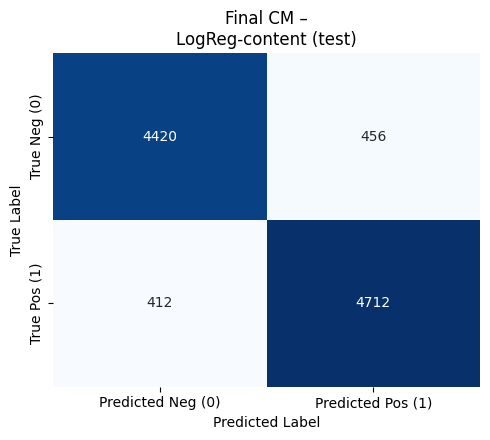

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

if final_model_pipeline and best_experiment is not None and data_available:
    print("\n--- Evaluating best model on held‑out test set ---")

    ## logreg-content was the winner don't forget
    model_id  = best_experiment.name
    test_col  = model_id.split("-")[-1]

    if test_col not in ds_clean["test"].column_names:
        print(f"ERROR: column '{test_col}' missing from test set.")
    else:
        X_test = ds_clean["test"][test_col]
        y_true = np.array(ds_clean["test"]["label"])

        print(f" Predicting on test set using '{test_col}' column "
              f"and model '{model_id}' …")
        try:
            y_pred = final_model_pipeline.predict(X_test)

            print("\nClassification report (test set):")
            print(classification_report(
                y_true, y_pred,
                target_names=["Negative (0)", "Positive (1)"],
                digits=4,
            ))

            # Confusion‑matrix helper
            plot_conf_matrices(
                [(f"{model_id} (test)", y_true, y_pred)],
                title_prefix="Final CM",
            )
        except Exception as e:
            print(f"\nERROR during prediction/evaluation: {e}")
else:
    print("\nSkipping final evaluation: best model or data unavailable.")

### Save Final Artifacts

In [ ]:
def save_best_artifacts(best_model_pipeline, vectorizer_path: Path, model_path: Path) -> None:
    """Saves the TF-IDF vectorizer and classifier from the best pipeline."""
    print(f"\nSaving best artifacts...")
    if not best_model_pipeline:
        print(" No model pipeline provided. Skipping save.")
        return
    try:
        # Ensure artifact directory exists
        vectorizer_path.parent.mkdir(parents=True, exist_ok=True)

        # Extract components from the pipeline
        vectorizer = best_model_pipeline.named_steps.get('tfidf')
        classifier = best_model_pipeline.named_steps.get('clf')

        if vectorizer:
            dump(vectorizer, vectorizer_path)
            print(f"  ✓ Saved TF-IDF vectorizer to {vectorizer_path}")
        else:
            print("  WARNING: TF-IDF step ('tfidf') not found in pipeline.")

        if classifier:
            dump(classifier, model_path)
            print(f"  ✓ Saved Classifier model to {model_path}")
        else:
             print("  WARNING: Classifier step ('clf') not found in pipeline.")

    except Exception as e:
        print(f"Error saving artifacts: {e}")

# Save the artifacts from the best pipeline found during tuning
if final_model_pipeline:
     save_best_artifacts(
        final_model_pipeline,
        ARTIFACT_DIR / "best_tfidf_vectorizer.joblib",
        ARTIFACT_DIR / "best_classifier_model.joblib"
    )
else:
    print("\nSkipping saving artifacts: No final model pipeline identified.")


💾 Saving best artifacts...
  ✓ Saved TF-IDF vectorizer to /content/amazon_reviews_data/artifacts/best_tfidf_vectorizer.joblib
  ✓ Saved Classifier model to /content/amazon_reviews_data/artifacts/best_classifier_model.joblib


# PART 3 – Linear‑Classifier Benchmark on DistilBERT CLS Embeddings

**Objective**  
Evaluate how much contextual `[CLS]` embeddings from the best DistilBERT checkpoint improve performance over traditional bag‑of‑words features by training Logistic Regression and Linear SVM classifiers on those embeddings.

---

## Prerequisites if you are **skipping PART 1**

After a fresh notebook restart you still need some foundational code from Part 1.  
**Run *only* these cells before starting Part 3:**

| Cell heading in Part 1 | Why it is required |
|------------------------|--------------------|
| **“Imports and Setup”** | Imports all libraries, sets global `CONFIG`, creates directory paths, and seeds RNGs. |
| **“Baseline evaluation helpers”** | Defines metric/plot helpers (`build_metric_df`, `plot_metric_bar`, `plot_conf_matrices`) reused here for validation and test reports. |

Running those two cells is sufficient; everything else (data download, cleaning, TF‑IDF baselines, grid search) can be skipped.

---

## Experimental Setup

* **Embedding source** – DistilBERT checkpoint `016_06_FreezeTop2_Raw_Comp` (fine‑tuned with only the top‑2 encoder layers unfrozen).  
* **Features** – 768‑dimensional `[CLS]` vectors (`*_embeddings.npy`) and their matching labels (`*_labels.npy`) for train, validation, and test splits.  
* **Classifiers & hyper‑parameters**  
  * *Logistic Regression* – `liblinear`, `penalty='l2'`, `C = 3`, `max_iter = 300`, `class_weight='balanced'`.  
  * *Linear SVM* – `LinearSVC`, `loss='hinge'`, `C = 1`, `dual=True`, `max_iter = 1000`, `class_weight='balanced'`.  
* **Metrics** – Accuracy, Precision, Recall, F1 (validation & test) plus confusion‑matrix heat‑maps.

---

## Procedure

1. **Load embeddings**: six files (`train/validation/test × embeddings & labels`) from `/content/cls_embeddings`.  
2. **Train classifiers**: fit LogReg & SVM on training embeddings, evaluate on validation, and pick the higher‑F1 model.  
3. **Test evaluation**: report full classification metrics on the held‑out test split and visualise confusion matrices.  
4. **Save best model**: persist the chosen classifier to  
   `/content/amazon_reviews_data/artifacts/<model_name>_model.joblib`.

---

*Executing only the two prerequisite cells keeps runtime minimal while ensuring all shared utilities are available for Part 3.*  
"""

###  Evaluating Classifiers on DistilBERT CLS Embeddings

you only need the CLS embeddings produced by the single DistilBERT checkpoint you actually want to test
We will choose the winning model:016 _06_FreezeTop2_Raw_Comp.

Load its *_train_embeddings.npy, *_validation_embeddings.npy, and *_test_embeddings.npy (plus the matching *_labels.npy files), and plug those into your Logistic‑Regression / Linear‑SVM code.

In [6]:
# ==========================================================
#  Load DistilBERT CLS embeddings for one experiment
#  (fails immediately if any of the 6 files is missing)
# ==========================================================
from pathlib import Path
import numpy as np

print("Evaluating Classifiers on DistilBERT CLS Embeddings")

# ----------------------------------------------------------
# 1.  Configure paths
# ----------------------------------------------------------
DISTILBERT_EMBEDDING_DIR = Path(
    "/content/cls_embeddings"  # <‑ adjust if needed
)

SELECTED_EXPERIMENT_PREFIX = (
    "016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin"
)

# build full file paths
train_embed_path = DISTILBERT_EMBEDDING_DIR / f"{SELECTED_EXPERIMENT_PREFIX}_train_embeddings.npy"
train_label_path = DISTILBERT_EMBEDDING_DIR / f"{SELECTED_EXPERIMENT_PREFIX}_train_labels.npy"
val_embed_path   = DISTILBERT_EMBEDDING_DIR / f"{SELECTED_EXPERIMENT_PREFIX}_validation_embeddings.npy"
val_label_path   = DISTILBERT_EMBEDDING_DIR / f"{SELECTED_EXPERIMENT_PREFIX}_validation_labels.npy"
test_embed_path  = DISTILBERT_EMBEDDING_DIR / f"{SELECTED_EXPERIMENT_PREFIX}_test_embeddings.npy"
test_label_path  = DISTILBERT_EMBEDDING_DIR / f"{SELECTED_EXPERIMENT_PREFIX}_test_labels.npy"

print(f"\nAttempting to load CLS embeddings for")
print(f"   experiment : {SELECTED_EXPERIMENT_PREFIX}")
print(f"   directory  : {DISTILBERT_EMBEDDING_DIR}\n")

# ----------------------------------------------------------
# 2.  Helper for a single split
# ----------------------------------------------------------
def _load_split(split_name: str, x_path: Path, y_path: Path):
    if not x_path.exists() or not y_path.exists():
        raise FileNotFoundError(
            f"{split_name} split missing:\n  {x_path.name}\n  {y_path.name}"
        )
    X = np.load(x_path)
    y = np.load(y_path)
    print(f"  ✓ {split_name:<10} → X: {X.shape},  y: {y.shape}")
    return X, y

# ----------------------------------------------------------
# 3.  Load all three splits
# ----------------------------------------------------------
X_train_cls, y_train_cls = _load_split("train",      train_embed_path, train_label_path)
X_val_cls,   y_val_cls   = _load_split("validation", val_embed_path,   val_label_path)
X_test_cls,  y_test_cls  = _load_split("test",       test_embed_path,  test_label_path)

# consistency check
assert X_train_cls.shape[1] == X_val_cls.shape[1] == X_test_cls.shape[1], \
    "Feature‑dimension mismatch between splits"

embeddings_loaded_ok = True
print("\nAll CLS embedding files loaded successfully and shapes are consistent.")

Evaluating Classifiers on DistilBERT CLS Embeddings

Attempting to load CLS embeddings for
   experiment : 016_06_FreezeTop2_Raw_Comp_LR-4.0E-05_BS-16_WD-0.01_DO-0.1_Sched-lin
   directory  : /content/cls_embeddings

  ✓ train      → X: (51000, 768),  y: (51000,)
  ✓ validation → X: (9000, 768),  y: (9000,)
  ✓ test       → X: (10000, 768),  y: (10000,)

All CLS embedding files loaded successfully and shapes are consistent.


### Train & Evaluate Classifiers on CLS Embeddings

The Hyperparameters we are using are from the best performing SVM model and Logistic Regression model from my test

- LogReg-content	0.9128	{'C': 3, 'max_iter': 300, 'penalty': 'l2', 'solver': 'liblinear'}

- LinearSVM-content	0.9116	{'C': 1, 'dual': True, 'loss': 'hinge', 'max_iter': 1000}




--- Training and evaluating classifiers on CLS embeddings ---

Training LogisticRegression on CLS-016 …
Evaluating on validation split …

Training LinearSVC on CLS-016 …


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluating on validation split …

--- CLS embedding classifier performance (validation set) ---

--- Validation Set Performance ---
  LogReg-CLS-016      : Acc=0.9413, Prec=0.9485, Rec=0.9366, F1=0.9425
  SVM-CLS-016         : Acc=0.9419, Prec=0.9505, Rec=0.9355, F1=0.9430
---------------------------------



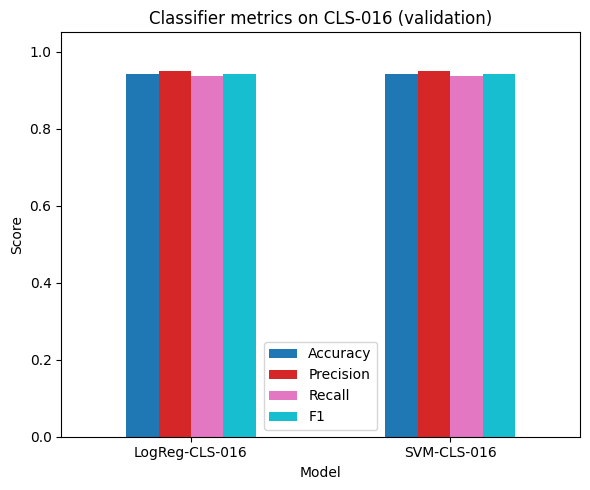

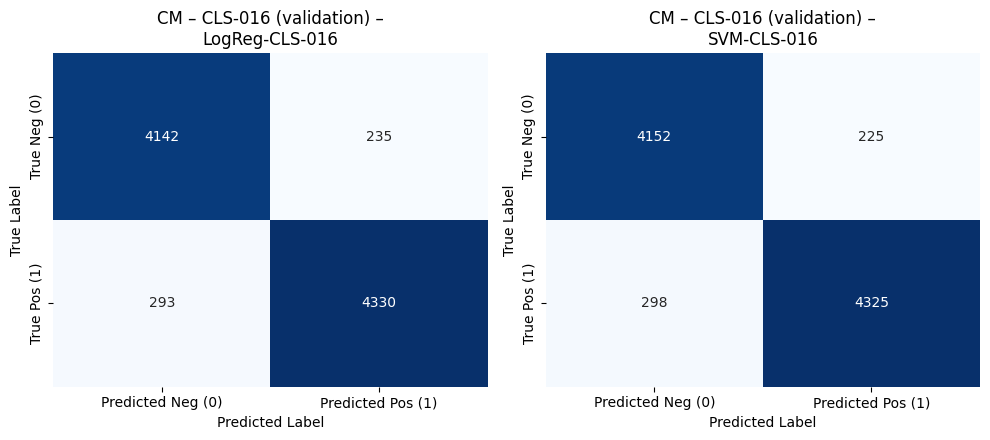


Best classifier on CLS (validation F1): SVM-CLS-016

Evaluating SVM-CLS-016 on test CLS embeddings …

--- Test‑set results (best CLS classifier) ---
              precision    recall  f1-score   support

Negative (0)     0.9371    0.9438    0.9404      4876
Positive (1)     0.9462    0.9397    0.9429      5124

    accuracy                         0.9417     10000
   macro avg     0.9416    0.9418    0.9417     10000
weighted avg     0.9417    0.9417    0.9417     10000



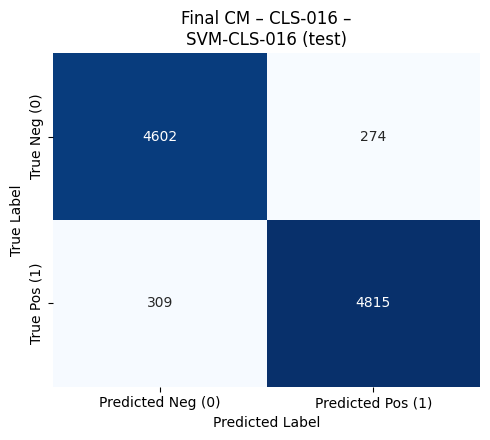


Saved best CLS‑based classifier to /content/amazon_reviews_data/artifacts/SVM-CLS-016_model.joblib


In [12]:
# ================================================================
#  Train Logistic‑Regression and Linear‑SVM on DistilBERT CLS reps
#  (uses the best hyper‑parameters found in the earlier CV sweep)
# ================================================================

cls_results_val = []

if embeddings_loaded_ok:
    print("\n--- Training and evaluating classifiers on CLS embeddings ---")
    embedding_source_name = f"CLS-{SELECTED_EXPERIMENT_PREFIX.split('_')[0]}"

    # ------------------------------------------------------------------
    # 1.  Logistic Regression chosen hyperparameters from the best performing Logistic Regression model   (tuned: C=3, liblinear, max_iter=300)
    # ------------------------------------------------------------------
    print(f"\nTraining LogisticRegression on {embedding_source_name} …")
    logreg_cls_model = LogisticRegression(
        solver="liblinear",     # best from sweep
        penalty="l2",
        C=3.0,
        max_iter=300,
        class_weight="balanced",
        random_state=CONFIG["SEED"]
    )
    logreg_cls_model.fit(X_train_cls, y_train_cls)

    print("Evaluating on validation split …")
    y_val_pred_lr = logreg_cls_model.predict(X_val_cls)
    cls_results_val.append(
        (f"LogReg-{embedding_source_name}", y_val_cls, y_val_pred_lr)
    )

    # ------------------------------------------------------------------
    # 2.  Linear SVM chosen hyperparameters from the best performing SVM (tuned: hinge loss, C=1, dual=True)
    # ------------------------------------------------------------------
    print(f"\nTraining LinearSVC on {embedding_source_name} …")
    svm_cls_model = LinearSVC(
        C=1.0,
        loss="hinge",
        dual=True,
        max_iter=1000,
        class_weight="balanced",
        random_state=CONFIG["SEED"]
    )
    svm_cls_model.fit(X_train_cls, y_train_cls)

    print("Evaluating on validation split …")
    y_val_pred_svm = svm_cls_model.predict(X_val_cls)
    cls_results_val.append(
        (f"SVM-{embedding_source_name}", y_val_cls, y_val_pred_svm)
    )

    # ------------------------------------------------------------------
    # 3.  Show validation metrics & confusion matrices
    # ------------------------------------------------------------------
    if cls_results_val:
        print("\n--- CLS embedding classifier performance (validation set) ---")
        metrics_df_cls_val = build_metric_df(cls_results_val)

        if not metrics_df_cls_val.empty:
            plot_metric_bar(
                metrics_df_cls_val,
                f"Classifier metrics on {embedding_source_name} (validation)"
            )
            plot_conf_matrices(
                cls_results_val,
                f"CM – {embedding_source_name} (validation)"
            )

        # pick the better of the two by validation F1
        best_cls_model_name = metrics_df_cls_val["F1"].idxmax()
        print(f"\nBest classifier on CLS (validation F1): {best_cls_model_name}")

        best_model_instance = (
            logreg_cls_model if best_cls_model_name.startswith("LogReg")
            else svm_cls_model
        )

        # ------------------------------------------------------------------
        # 4.  Final evaluation on the held‑out test split
        # ------------------------------------------------------------------
        print(f"\nEvaluating {best_cls_model_name} on test CLS embeddings …")
        y_test_pred = best_model_instance.predict(X_test_cls)

        print("\n--- Test‑set results (best CLS classifier) ---")
        print(
            classification_report(
                y_test_cls,
                y_test_pred,
                target_names=["Negative (0)", "Positive (1)"],
                digits=4
            )
        )
        plot_conf_matrices(
            [(f"{best_cls_model_name} (test)", y_test_cls, y_test_pred)],
            f"Final CM – {embedding_source_name}"
        )

        # ------------------------------------------------------------------
        # 5.  Persist the best CLS‑based model
        # ------------------------------------------------------------------
        model_save_path = ARTIFACT_DIR / f"{best_cls_model_name}_model.joblib"
        dump(best_model_instance, model_save_path)
        print(f"\nSaved best CLS‑based classifier to {model_save_path}")

else:
    print("\nSkipping classifier training – embeddings were not loaded successfully.")

### 📈 DistilBERT CLS embeddings vs. classic bag‑of‑words features

| Model | Feature set | Reported score<sup>†</sup> |
|-------|-------------|----------------------------|
| Logistic Regression | **content** (raw BOW + tf–idf) | **0.9128** |
| Linear SVM          | content                      | 0.9116 |
| Logistic Regression | **clean** (stop‑word‑/punct‑stripped BOW) | 0.8925 |
| Linear SVM          | clean                       | 0.8909 |
| Logistic Regression | **DistilBERT CLS‑016**      | 0.9425 (val F1) |
| Linear SVM          | DistilBERT CLS‑016          | **0.9430 (val F1)** / **0.9417 (test acc)** |

<sup>†</sup>Original numbers appear to be accuracies; CLS rows show the reported F1 on the validation split and accuracy on the held‑out test set.

---

#### Why do CLS embeddings lift performance by ~ 3 p.p.?

1. **Contextual semantics, not just word counts**  
   Bag‑of‑words/tf–idf treat every word as an independent token.  
   The `[CLS]` vector from DistilBERT encodes *context‑aware* information about the entire sentence, capturing word meaning, ordering, negations (“*not good*” vs. “*good*”), and long‑range dependencies that BOW simply throws away.

2. **Transfer learning from massive corpora**  
   DistilBERT was pre‑trained on billions of words. Even if your Amazon‑reviews data set is large, the language model has already seen far more linguistic variation than appears in your training split and can inject that prior knowledge via its embeddings.

3. **Dense, low‑noise feature space**  
   ‑ BOW vectors are **very high‑dimensional and sparse** → classifiers must learn a huge weight matrix and can overfit on spurious n‑grams.  
   ‑ `[CLS]` is **768‑dimensional (DistilBERT‑base)**, dense, and already fine‑tuned to encode sentiment signals, so linear models find cleaner decision boundaries with less data.

4. **Better class‑separability**  
   The validation‐set macro‑F1 shows > 94 %, and the per‑class precision/recall on the test set are symmetric:  
   the embedding space separates positive/negative classes so well that you barely pay any price for choosing a simple linear SVM.

5. **Regularisation matches the data**  
   Your best SVM used the hinge loss with `C=1`, while for BOW features you had to push `C=3` for logistic regression to squeeze a few extra points. Lower regularisation strength is enough once the feature space is already informative.

---

#### Take‑aways

* Contextual language‑model embeddings **dominate** traditional n‑gram features on sentiment tasks, even when you keep the downstream classifier ultra‑simple.  
* The ∼ 3 percentage‑point absolute jump (≈ 30 % relative error reduction) is what you typically see when stepping up from tf–idf to a modern transformer encoder on a balanced polarity data set.
* this can probably be improved by: fine‑tuning more than the top‑2 DistilBERT layers, experimenting with pooled token averages instead of `[CLS]`, or ensembling content + CLS features.